# Nesting Designs, version 6

## Load packages.

In [1]:
require(abind)
require(data.table)
require(deSolve)
require(magrittr)
require(rTensor)

require(ggplot2)
require(GGally)


Loading required package: abind
Loading required package: data.table
Loading required package: deSolve
Loading required package: magrittr
Loading required package: rTensor
Loading required package: ggplot2
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


## Function to generate simulations.

In [2]:
# Create a multivariate function with specified properties:
#   tmax: maximum time
#   multiplicities: number of correlations each parameter has
#   degrees: polynomial degree of each parameter
#   dimension: the dimension of the output
#   returns a multivariate function of the vector of parameters and time
makeGenerator <- function(multiplicities, degrees, dimension) {

    single <- function(degree) {
      x0 <- runif(1)
      z0 <- runif(1)
      function(x) {
          if (x < x0)
              0
          else
              z0 * (x - x0)^degree
      }
    }
  
    locations <- lapply(multiplicities, function(m) sample(1:dimension, m))
    functions <- lapply(degrees, single)
    
    start <- runif(dimension, -0.25, 0.75)
    coefs <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)    
    shift <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)
    
    function(x, ts) {
        z <- rep(0, dimension)
        for (i in 1:length(locations))
            for (j in locations[[i]])
                z[j] <- z[j] + functions[[i]](x[i])
        ode(start, ts, function(t, y, params) {list((coefs %*% y) * z * (1 - ((shift %*% y) * z)))})
    }
    
}


## Functions for nesting designs

In [3]:
ssa.digits <- 30

In [4]:
ssa.scale <- 2^ssa.digits

In [5]:
ssa.level <- function(i) {
    if (i == 0)
        return(ssa.digits)
    n <- 0
    while (bitwAnd(i, 1) == 0) {
        n <- n + 1
        i <- bitwShiftR(i, 1)
    }
    n
}

In [6]:
ssa.depth <- function(i) {
    ssa.digits - ssa.level(i)
}

In [7]:
ssa.corner <- function(i, offset=0){
    d <- ssa.level(i) - offset
    c(i - 2^d, i + 2^d)
}

In [8]:
ssa.corners <- function(i1, i2, i3, offset=0) {
    axis <- function(s1, s2, s3) {
        if (s1 == 0)
            4 * s1 + 2 * s2 + s3
        else
            4 * (1 - s1) + 2 * (1 - s2) + (1 - s3)
    }
    merge(merge(merge(
        data.table(
            d1 = 1,
            d2 = 2,
            d3 = 4
        ),
        data.table(d1=1, i1=ssa.corner(i1, offset=offset), s1=0:1), by="d1", allow.cartesian=TRUE),
        data.table(d2=2, i2=ssa.corner(i2, offset=offset), s2=0:1), by="d2", allow.cartesian=TRUE),
        data.table(d3=4, i3=ssa.corner(i3, offset=offset), s3=0:1), by="d3", allow.cartesian=TRUE
    )[,
    .(
        i1,
        i2,
        i3,
        axis=mapply(axis, s1, s2, s3)
    )]
}

In [9]:
ssa.candidates <- function(i1, i2, i3) {
    CJ(
        i1=c(i1, ssa.corner(i1)),
        i2=c(i2, ssa.corner(i2)),
        i3=c(i3, ssa.corner(i3))
    )[,
        .(
            i1,
            i2,
            i3,
            x1 = i1 / ssa.scale,
            x2 = i2 / ssa.scale,
            x3 = i3 / ssa.scale
        )
    ]
}

In [10]:
ssa.start <- function() {
    result <- CJ(
        i1=c(0, ssa.scale),
        i2=c(0, ssa.scale),
        i3=c(0, ssa.scale)
    )[,
        .(
            sequence = 1:8     ,
            generation = 0     ,
            i1                 ,
            i2                 ,
            i3                 ,
            x1 = i1 / ssa.scale,
            x2 = i2 / ssa.scale,
            x3 = i3 / ssa.scale,
            compute = TRUE     ,
            measure = FALSE    ,
            probed  = TRUE     ,
            s1 = 0             ,
            s2 = 0             ,
            s3 = 0             ,
            s  = 0
        )
    ]
    result <- rbind(
        result,
        data.table(
            sequence = 9      ,
            generation = NA   ,
            i1 = ssa.scale / 2,
            i2 = ssa.scale / 2,
            i3 = ssa.scale / 2,
            x1 = 0.5          ,
            x2 = 0.5          ,
            x3 = 0.5          ,
            compute = FALSE   ,
            measure = TRUE    ,
            probed  = FALSE   ,
            s1 = 0. / 0.      ,
            s2 = 0. / 0.      ,
            s3 = 0. / 0.      ,
            s  = 0. / 0.
        )
    )
    setkeyv(result, c("i1", "i2", "i3"))
}

In [11]:
ssa.compute <- function(f, ts, xs, ys) {
    needed <- xs[compute == TRUE]
    for (row in 1:nrow(xs)) {
        ys <- rbind(
            ys,
            data.table(f(as.numeric(xs[row, .(x1, x2, x3)]), ts))[,
                .(
                    sequence = xs[row, sequence],
                    t = time,
                    y1 = `1`,
                    y2 = `2`,
                    y3 = `3`
                )
            ]
        )
    }
    xs[compute == TRUE, compute := FALSE]
    ys
}

In [12]:
ssa.measure <- function(xs, ys, focus=2) {
    
    result <- merge(
        merge(
            xs[measure == TRUE][, ssa.corners(i1, i2, i3), by=.(center=sequence)],
            xs,
            by=c("i1", "i2", "i3"),
            allow.cartesian=TRUE
        )[, .(center, axis, sequence)],
        ys,
        by="sequence",
        allow.cartesian=TRUE
    )[,
        .(y1 = mean(y1), y2 = mean(y2), y3 = mean(y3)), by=.(sequence=center, axis, t)
    ][,
        .(s1 = sd(y1), s2 = sd(y2), s3 = sd(y3)), by=.(sequence, t)
    ][,
        .(s1 = max(s1), s2 = max(s2), s3 = max(s3)), by=sequence
    ]

    xs[
        sequence %in% result$sequence,
        `:=`(
            s1=result$s1,
            s2=result$s2,
            s3=result$s3,
            generation=xs[, 1 + max(generation, na.rm=TRUE)]
        )
    ]
    
    y1min = min(ys$y1)
    y1max = max(ys$y1)
    y2min = min(ys$y2)
    y2max = max(ys$y2)
    y3min = min(ys$y3)
    y3max = max(ys$y3)

    normalize <- function (i, s1, s2, s3)
        max(s1 / (y1max - y1min), s2 / (y2max - y2min), s3 / (y3max - y3min)) * focus^ssa.depth(i)
    xs[, `:=`(measure = FALSE, s = mapply(normalize, i1, s1, s2, s3))]
    
    result
}

In [13]:
ssa.probe <- function(xs) {
    probe <- xs[
        probed == FALSE,
        .(sequence, i1, i2, i3, rank=frank(-s, ties.method="random"))
    ][
        rank == 1,
        .(sequence, i1, i2, i3)
    ]
    candidates <- ssa.candidates(probe$i1, probe$i2, probe$i3)
    setkeyv(candidates, c("i1", "i2", "i3"))
    candidates <- candidates[!xs]
    candidates <- candidates[, .(
        sequence = xs[, max(sequence)] + (1:nrow(candidates)),
        generation = NA,
        i1, i2, i3,
        x1, x2, x3,
        compute = TRUE ,
        measure = FALSE,
        probed  = FALSE,
        s1 = 0. / 0.,
        s2 = 0. / 0.,
        s3 = 0. / 0.,
        s  = 0. / 0.
    )]
    probes <- ssa.corners(probe$i1, probe$i2, probe$i3, offset=1)
    probes <- probes[, .(
        sequence = max(candidates$sequence) + (1:nrow(probes)),
        generation = NA,
        i1, i2, i3,
        x1 = i1 / ssa.scale,
        x2 = i2 / ssa.scale,
        x3 = i3 / ssa.scale,
        compute = FALSE,
        measure = TRUE ,
        probed  = FALSE,
        s1 = 0. / 0.,
        s2 = 0. / 0.,
        s3 = 0. / 0.,
        s  = 0. / 0.
    )]
    result <- rbind(
        xs,
        candidates,
        probes
    )
    result[sequence == probe$sequence, `:=`(compute=TRUE, measure=FALSE, probed=TRUE)]
    setkeyv(result, c("i1", "i2", "i3"))
    list(
        sequence=probe$sequence,
        xs=result
    )
}

## Reproducible random numbers.

In [14]:
RNGkind("Mersenne-Twister", "Inversion", "Rejection")

In [15]:
set.seed(46)

## Create a simulation function.

In [16]:
f <- makeGenerator(c(2, 2, 3), c(0, 1, 2), 3)

## Example application

### Set time resolution.

In [17]:
ts <- (0:20) / 2

### Initialize experiment at bounds of domain.

In [18]:
xs <- ssa.start()

In [19]:
xs

sequence,generation,i1,i2,i3,x1,x2,x3,compute,measure,probed,s1,s2,s3,s
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0.0,0.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
2,0,0,0,1073741824,0.0,0.0,1.0,TRUE,FALSE,TRUE,0,0,0,0
3,0,0,1073741824,0,0.0,1.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
4,0,0,1073741824,1073741824,0.0,1.0,1.0,TRUE,FALSE,TRUE,0,0,0,0
9,NA,536870912,536870912,536870912,0.5,0.5,0.5,FALSE,TRUE,FALSE,NaN,NaN,NaN,NaN
5,0,1073741824,0,0,1.0,0.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
6,0,1073741824,0,1073741824,1.0,0.0,1.0,TRUE,FALSE,TRUE,0,0,0,0
7,0,1073741824,1073741824,0,1.0,1.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
8,0,1073741824,1073741824,1073741824,1.0,1.0,1.0,TRUE,FALSE,TRUE,0,0,0,0


### Iterate several times.

In [20]:
ys <- NULL
sequences <- NULL

In [21]:
for (k in 1:250) {
    # Perform pending computations.
    ys <- ssa.compute(f, ts, xs, NULL)
    # Measure divergences.
    ssa.measure(xs, ys, focus = 1)
    # Select where to probe further.
    result <- ssa.probe(xs)
    # Tally results.
    sequences <- rbind(
        sequences,
        xs[
            sequence == result$sequence,
            .(
                sequence,
                x1, x2, x3,
                generation,
                depth=mapply(ssa.depth, i1))
        ]
    )
    # Update grid.
    xs <- result$xs
}
sequences

sequence,x1,x2,x3,generation,depth
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,0.5000,0.5000,0.5000,1,1
33,0.7500,0.2500,0.7500,2,2
35,0.7500,0.7500,0.7500,2,2
56,0.6250,0.3750,0.6250,3,3
55,0.6250,0.1250,0.8750,3,3
76,0.6250,0.6250,0.8750,4,3
78,0.6250,0.8750,0.8750,4,3
57,0.6250,0.3750,0.8750,3,3
58,0.8750,0.1250,0.6250,3,3


### Save results.

In [22]:
write.table(xs, file="xs-v6.csv", row.names=FALSE, sep=",")
xs %>% dim

[1] 5403   15

In [23]:
write.table(ys, file="ys-v6.csv", row.names=FALSE, sep=",")
ys %>% dim

[1] 112917      5

### Plot sampling pattern.

#### Distribution of discrepancies, distinguished by depth.

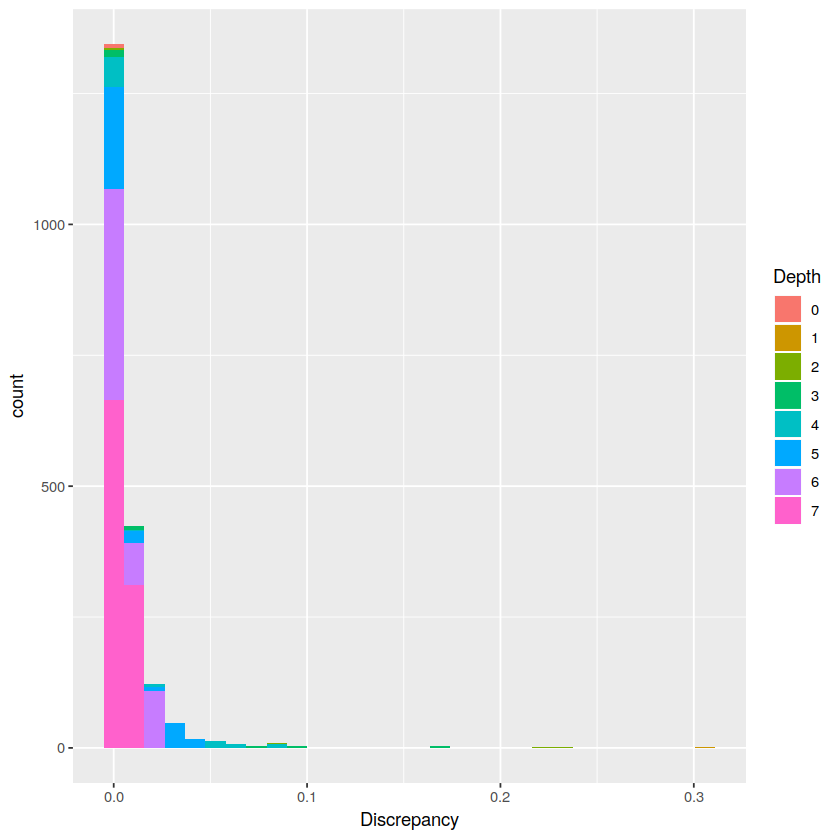

In [24]:
ggplot(
    xs[!is.na(generation), .(Generation=factor(generation), Discrepancy=s, Depth=factor(mapply(ssa.depth, i1)))],
    aes(x=Discrepancy, fill=Depth)
) + geom_histogram(bins = 30)

#### Distribution of discrepancies, distinguished by generation.

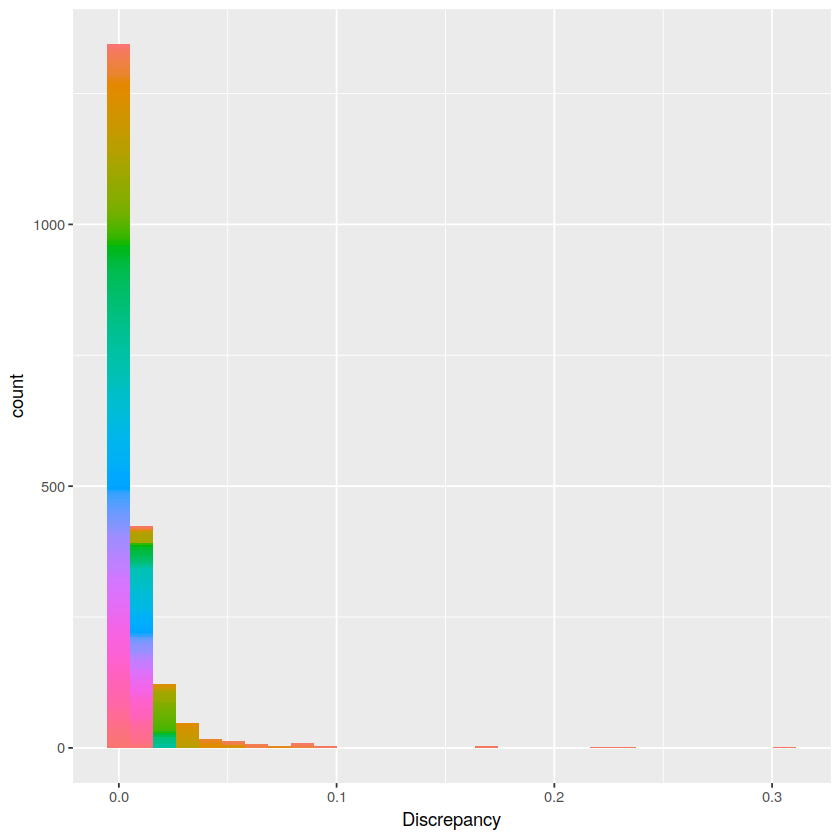

In [25]:
ggplot(
    xs[!is.na(generation), .(Generation=factor(generation), Discrepancy=s, Depth=factor(mapply(ssa.depth, i1)))],
    aes(x=Discrepancy, fill=Generation)
) + geom_histogram(bins = 30)  + theme(legend.position = "none")

#### Discrepancies and depth as a function of generation.

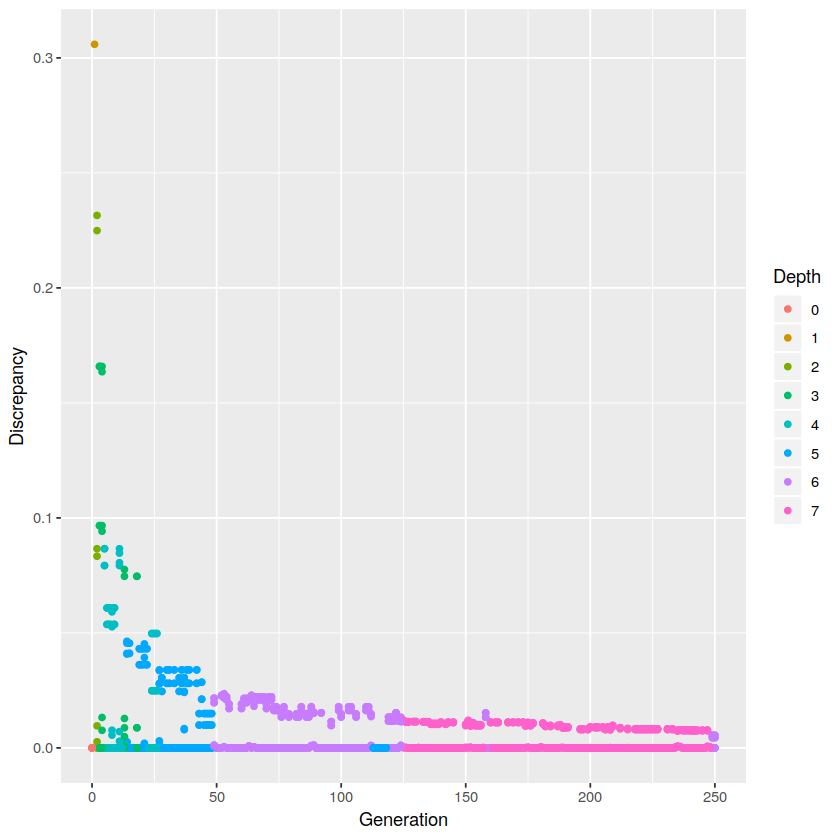

In [26]:
ggplot(
    xs[!is.na(generation), .(Generation=generation, Discrepancy=s, Depth=factor(mapply(ssa.depth, i1)))],
    aes(x=Generation, y=Discrepancy, color=Depth)
) + geom_point()

#### Marginal densities of sampling.

##### `x1` vs `x2`.

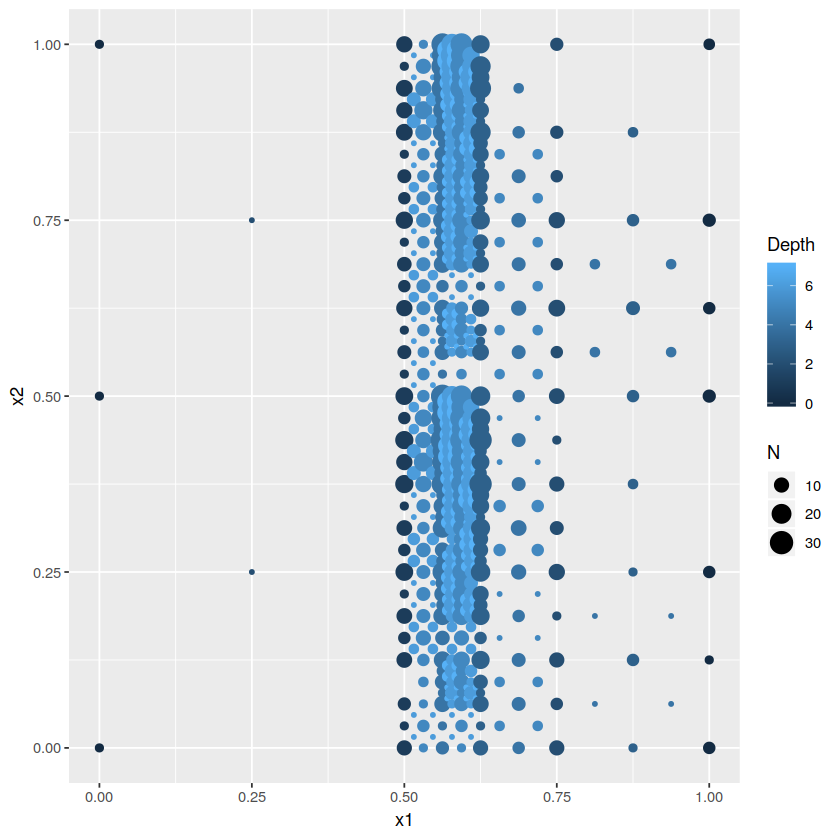

In [27]:
ggplot(
    xs[compute == FALSE, .(N=.N, Depth=max(mapply(ssa.depth, i1))), by=.(x1, x2)],
    aes(x=x1, y=x2, size=N, color=Depth)
) + geom_point()

##### `x2` vs `x3`.

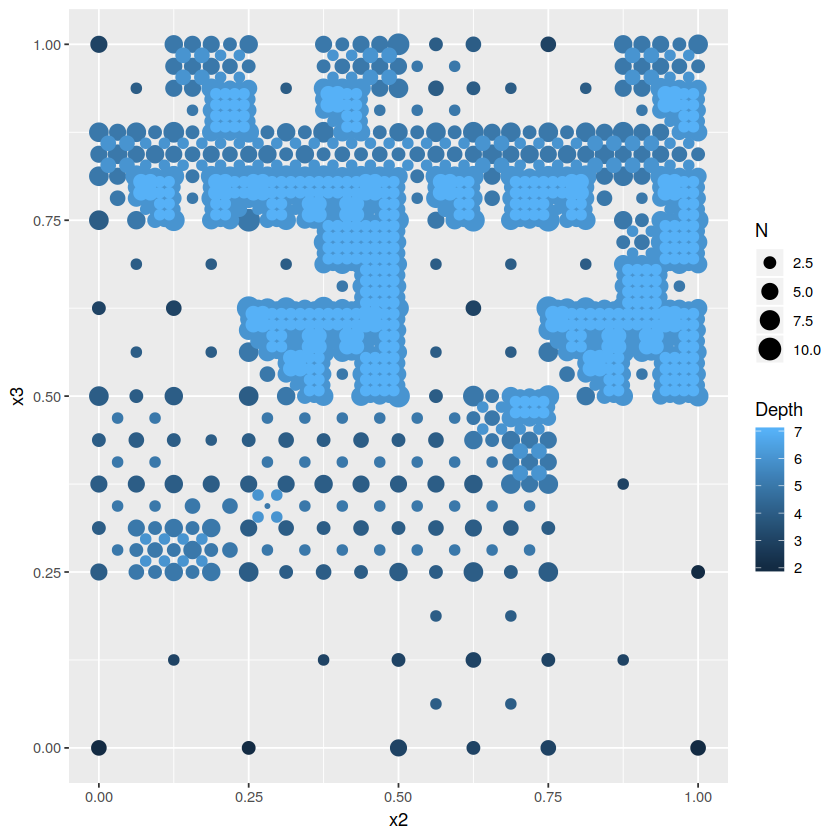

In [28]:
ggplot(
    xs[compute == FALSE, .(N=.N, Depth=max(mapply(ssa.depth, i1))), by=.(x2, x3)],
    aes(x=x2, y=x3, size=N, color=Depth)
) + geom_point()

##### `x3` vs `x1`.

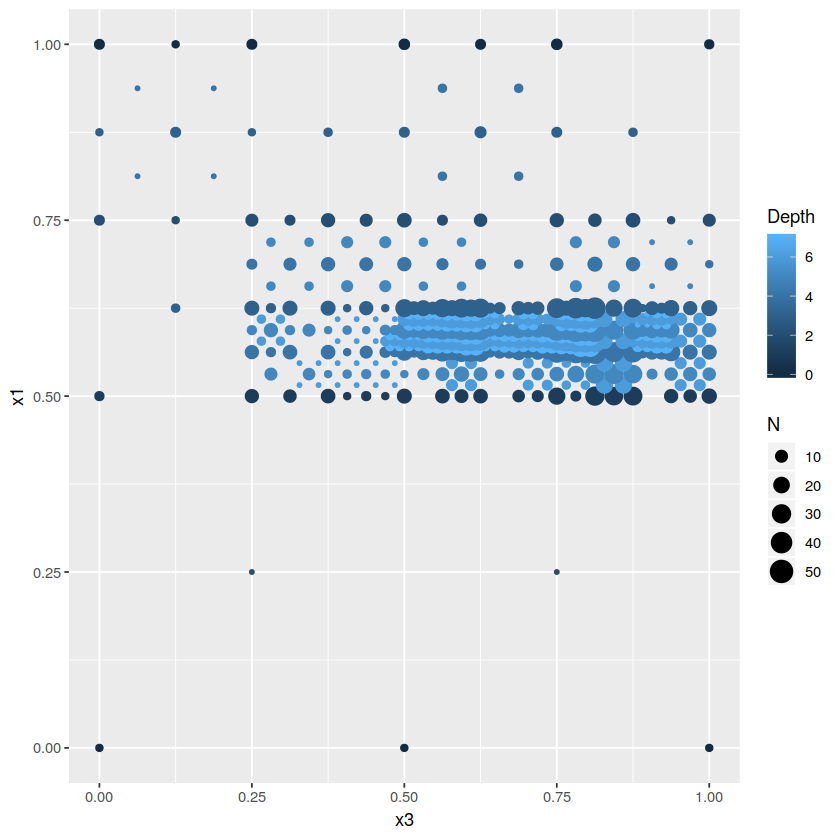

In [29]:
ggplot(
    xs[compute == FALSE, .(N=.N, Depth=max(mapply(ssa.depth, i1))), by=.(x3, x1)],
    aes(x=x3, y=x1, size=N, color=Depth)
) + geom_point()

#### Pairs.

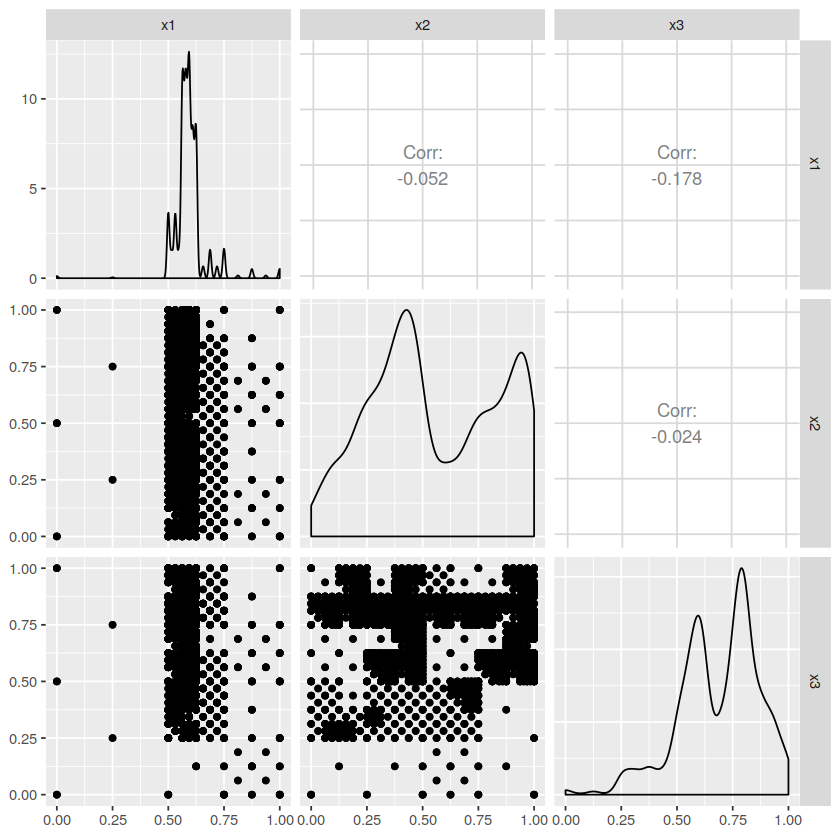

In [30]:
ggpairs(xs, 6:8)